<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
Author: [Dmitry Sergeyev](https://github.com/DmitrySerg), Zeptolab. All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9.
## <center> Time series analysis

**Fill the missing code in cells and choose answers in the [web-form](https://docs.google.com/forms/d/1ZeumydsDYMm-Kw8rOW-NGVF_edLArGUsupR3BVj5Ov4/edit).**

Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We will take real time-series data of total ads watched by hour in one of our games.

In [2]:
df = pd.read_csv('../../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

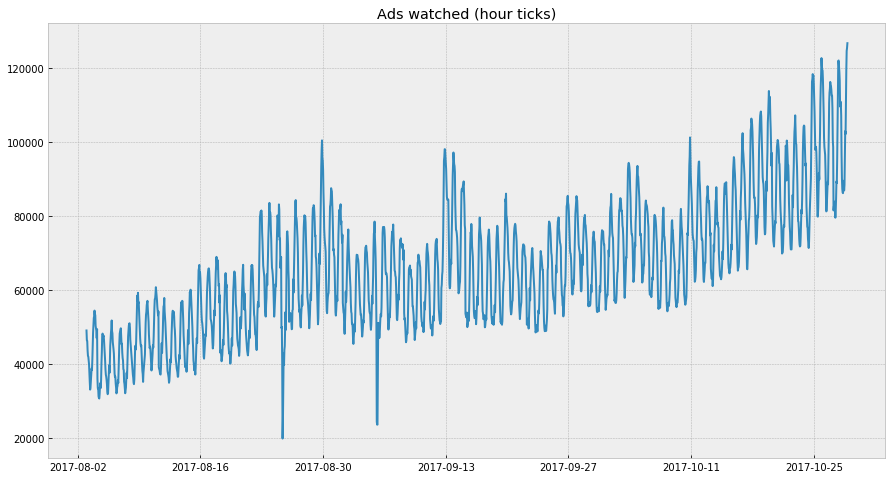

In [3]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

We have everything you could ask for - trend, seasonality, even some outliers.

In this assignment we will concentrate on methods that have proven to be working in practice and can provide quality, comparable to ARIMA models. Namely, feature engineering, selecting and machine learning

Let's take two useful functions from the lecture material - one for target encoding and the other for train and test datasets preparation

In [4]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=14, test_size=0.15, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    test_index = int(len(data) * (1 - test_size))
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Use the functions on original `df` to prepare datasets necessary for model training. Reserve 30% of data for testing, use initial lag 12 and final lag 48. This way the model will be able to make forecasts twelve steps ahead, having observed data from the previous 1.5 day. 

Scale the resulting datasets with the hekp of `StandardScaler` and create new variables - `X_train_scaled` and `X_test_scaled`. Don't forget that `scaler` should be trained on train set only to prevent information about future from leaking.

In [5]:
df.shape

(2085, 1)

In [6]:
# Your code here
X_train, X_test, y_train, y_test = prepareData(df, lag_start=12, lag_end=48, test_size=0.3)
print (X_train.shape, X_test.shape)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1460, 39) (579, 39)


Now train a simple linear regression on scaled data:

In [7]:
# Your code here
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Check the quality of the model on the train set with the help of cross-validation. To do so you need to create an  object-generator of time series cv folds with the help of `TimeSeriesSplit`. Set the number of folds to be equal 5. Then use `cross_val_score`, feeding it's `cv` parameter with the created generator. Quality metrics should be `neg_mean_absolute_error`.

Don't forget to take an average of the result and multiply it by -1.

In [8]:
# Your code here
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(lr, X_train_scaled, y_train, cv = tscv, scoring='neg_mean_absolute_error')
print(scores)
print(-scores.mean())

[-5472.53540649 -5566.82442968 -6186.5112431  -4074.24771239
 -4081.44032865]
5076.311824059032


<font color='red'>Task 1.</font> What is the value of MAE on cross-validation?
- 4876
- 50962872
- ##### 5076 
- 0.638

Now let's have a look at the forecast itself. We'll need `plotModelResults` function. You should complete the part, responsible for prediction interval calculation. To calculate the intervals use the same method as above, but you will need to get both average MAE and its std on different folds.

In [9]:
def plotModelResults(model, X_train, X_test, plot_intervals=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # Your code here
        cv = cross_val_score(model, X_train, y_train, cv = tscv, scoring='neg_mean_absolute_error')

        mae = -cv.mean()
        deviation = cv.std()
        
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        pass
        
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

For model coefficients visualization use the following functions:

In [10]:
def getCoefficients(model):
    """
        Returns sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

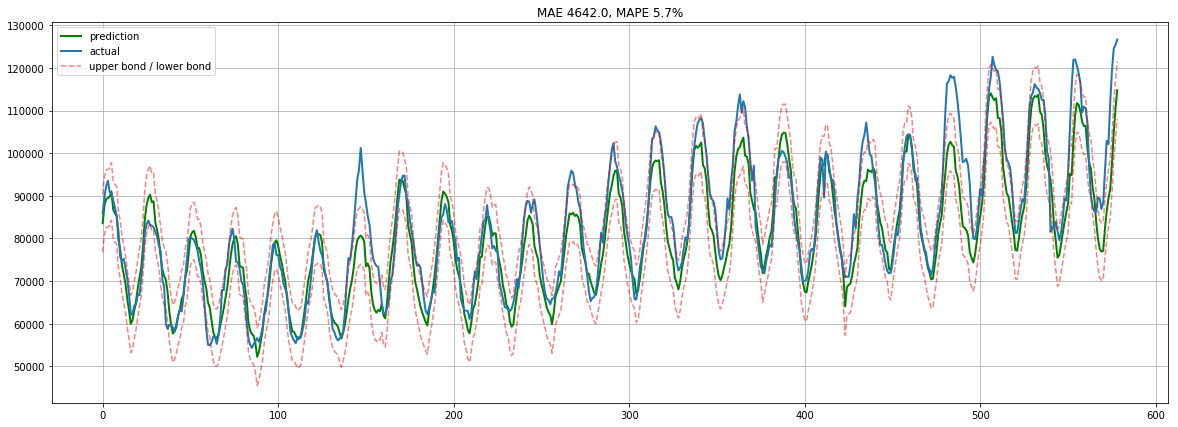

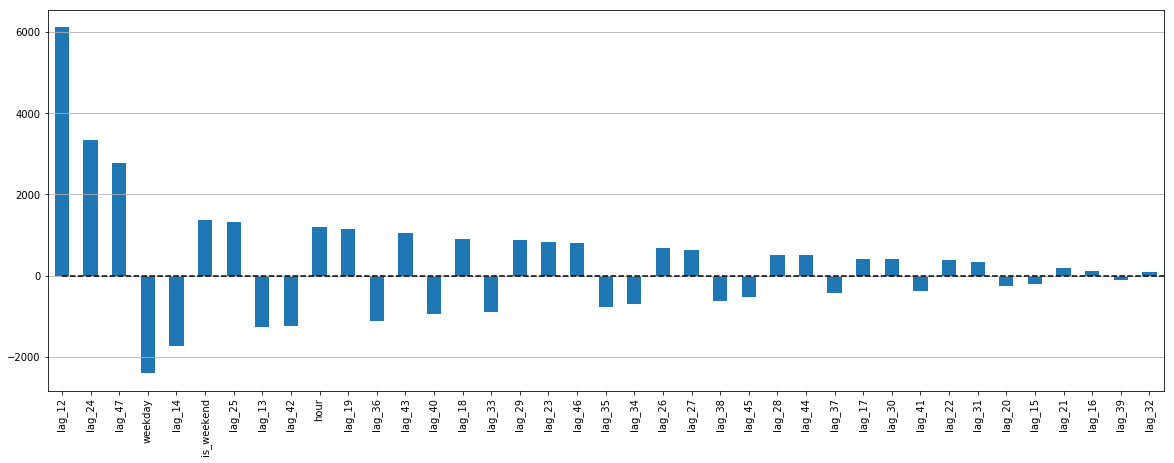

In [11]:
plotModelResults(lr, X_train_scaled, X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Wonderful, the intervals are plotted, forecast quality is great and everything seems to be fine, but...We might be having too many variables in our model and, possibly, some of them are not that important and can totally be  dropped. To make sure we have extra features, plot a heatmape of `X_train` data correlations with the help of `heatmap` function from `seaborn` library:

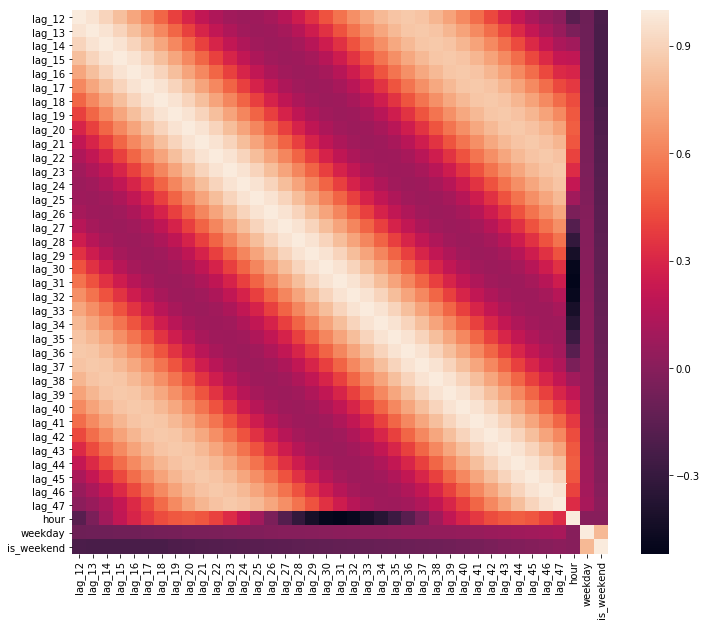

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr());

Indeed, features are highly  correlated and you can even observe some kind of "seasonality" in those correlations on each 24-th lag. Let's try to add regularization to our models and remove some features. 

Train Lasso regression on cross-validation (`LassoCV`) again feeding the `cv` parameter with the created generator-object. 

Plot the forecast of the model and notice that the error on test dataset has not increased significantly 

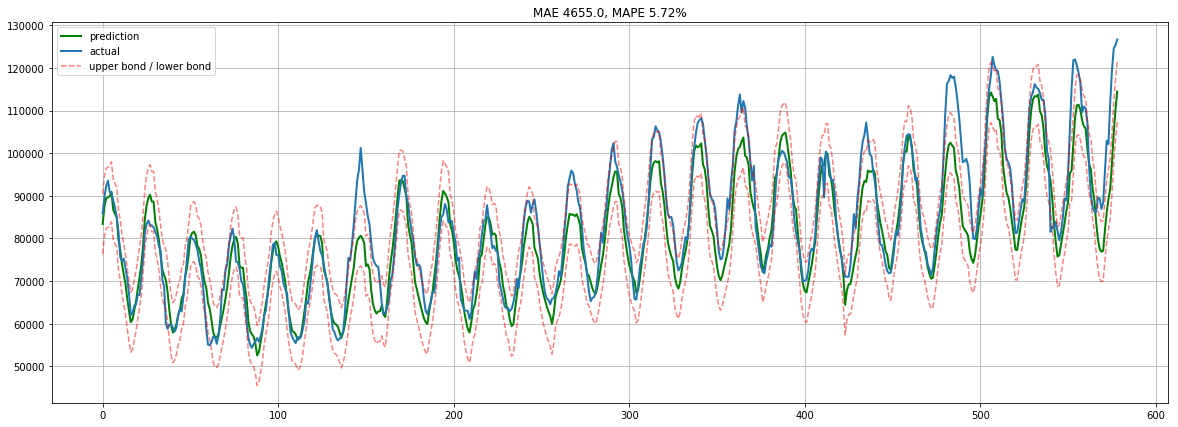

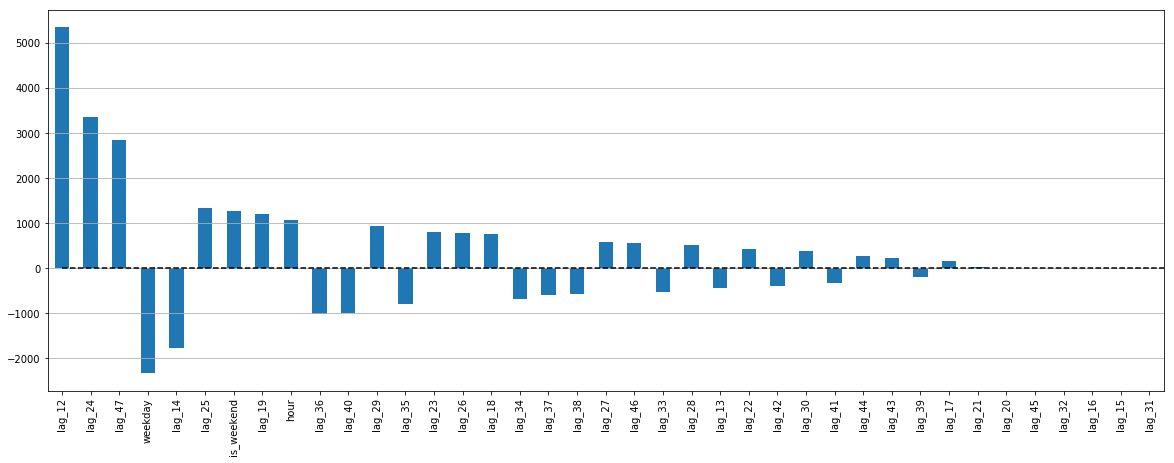

In [13]:
# Your code here
lasso = LassoCV(cv=tscv, n_jobs=-1)
lasso.fit(X_train_scaled, y_train)
plotModelResults(lasso, X_train_scaled, X_test_scaled, plot_intervals=True)
plotCoefficients(lasso)

Perfect, we are still having good model quality, the intervals are almost intact and we have less features. Use the function `getCoefficients` and find, how many features are now dropped (coefficient equals zero).

In [14]:
# Your code here
coefs = getCoefficients(lasso)
print(coefs.loc[np.isclose(coefs['coef'], 0.0, atol=1e-6)].shape[0])
coefs.loc[np.isclose(coefs['coef'], 0.0, atol=1e-6)]

6


,coef
lag_20,0.0
lag_45,0.0
lag_32,-0.0
lag_16,0.0
lag_15,-0.0
lag_31,0.0


<font color='red'>Task 2.</font> How many coefficients of Lasso model equal zero? (with 6 digit precision)?

- 1
- 7
- 5
- ##### 6

Alright, we have some features dropped. But what if we want to go further and transform our linear-dependant features into more compact representation? To do wo we'll use principal component analysis.

In [15]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA():
    """
    Plots accumulated percentage of explained variance by component
    """
    features = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(features, variance)
    
    # additionally mark the level of 95% of explained variance 
    plt.hlines(y = 95, xmin=0, xmax=len(features), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

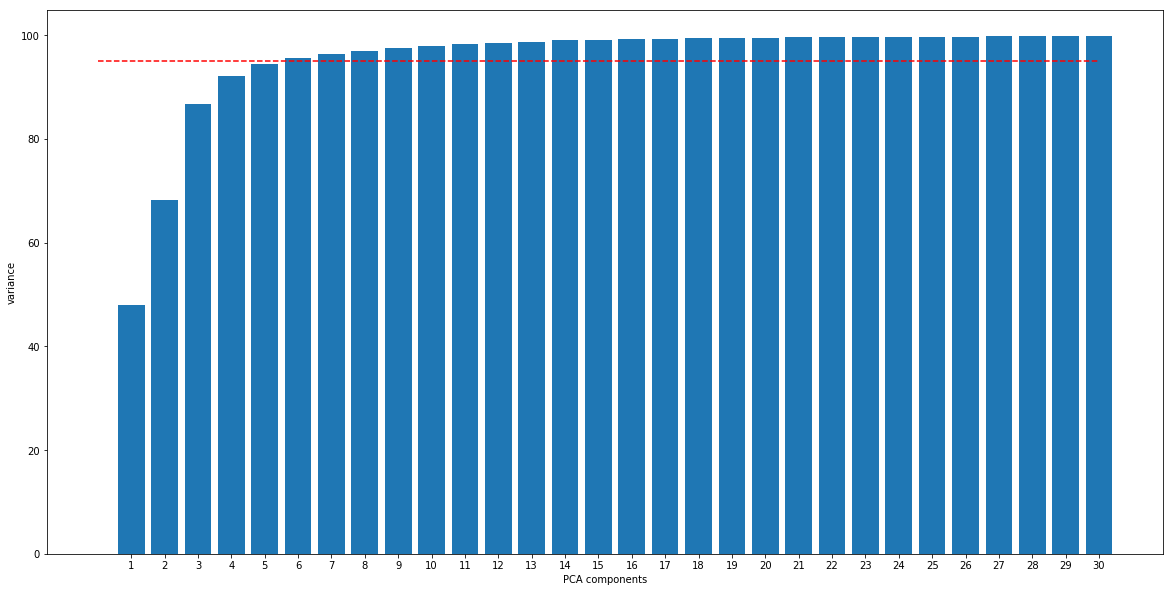

In [19]:
from sklearn.decomposition import PCA
# Create PCA object: pca
pca = PCA(n_components=30)
# Train PCA on scaled data
pca.fit(X_train_scaled)
# plot explained variance
plotPCA()

<font color='red'>Task 3.</font> What is the minimal number of components needed to explain **at least** 95% of variance of the train dataset?

- 4
- 5
- ##### 6 
- 7

Create the `pca` object again, setting inside it the optimal number of components (explaining at least 95% of variance). After that create two new variables - `pca_features_train` and `pca_features_test`, assigning to them pca-transformed scaled datasets.

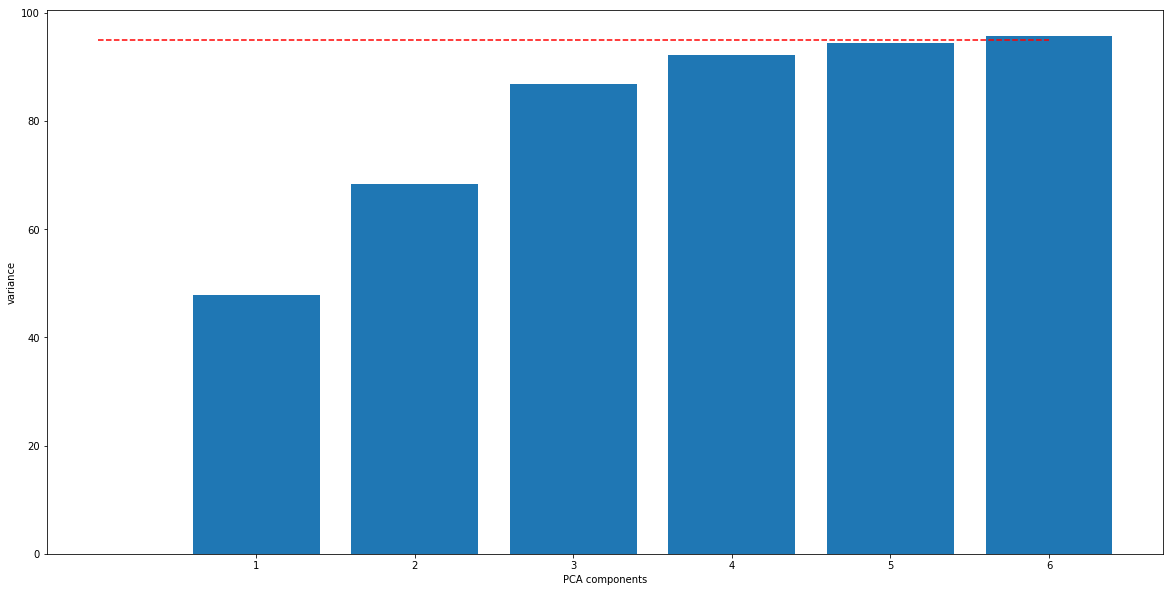

In [20]:
# Your code here
pca = PCA(n_components=6)
# Train PCA on scaled data
pca_features_train = pca.fit_transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)
# plot explained variance
plotPCA()

Now train linear regression on pca features and plot its forecast.

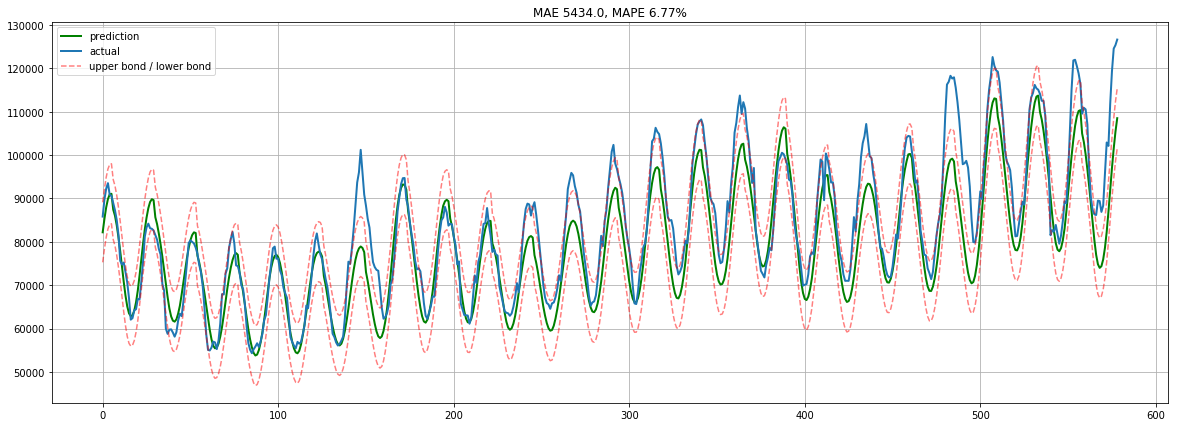

In [23]:
# Your code here
lr = LinearRegression()
lr.fit(pca_features_train, y_train)
#pca_pred = lr.transform(pca_features_test)
plotModelResults(lr, pca_features_train, pca_features_test, plot_intervals=True)

<font color='red'>Task 4.</font> What is the MAE of linear regression, trained on pca-transformed features? 
- 5140
- 4917
- 6719
- ##### 5434 